<h1>ChEMBL</h1>

In [1]:
import os
import seaborn
import requests
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

import ChEMBL as chembl

<h2>Loading pdbbind core-set information</h2>

<h4>Cluster id</h4>

In [2]:
f = './refined-set/index/INDEX_core_cluster.2016'
clusters = pd.read_csv(f, sep='\s+', usecols=[0, 5], 
                       names=['pdb_id', 'cluster_id'], comment='#')
clusters.head()

,pdb_id,cluster_id
0,1ps3,3
1,3dx1,3
2,3d4z,3
3,3dx2,3
4,3ejr,3


<h4>Uniprot id</h4>

In [3]:
f = './refined-set/index/INDEX_general_PL_name.2016'
uniprot = pd.read_csv(f, sep='\s+', usecols=[0, 2], 
                      names=['pdb_id', 'uniprot_id'], comment='#')
uniprot.head()

,pdb_id,uniprot_id
0,3eql,Q9Z9H6
1,1zyr,Q5SHR6
2,3dxj,Q5SHR6
3,4zh4,P0A7Z4
4,4zh3,P0A7Z4


<h4>Merge</h4>

In [4]:
data_pdb = clusters.merge(uniprot, on='pdb_id')
data_pdb.to_csv('pdbbind_data', index=False)
data_pdb.head()

,pdb_id,cluster_id,uniprot_id
0,1ps3,3,Q24451
1,3dx1,3,Q24451
2,3d4z,3,Q24451
3,3dx2,3,Q24451
4,3ejr,3,Q24451


<h3>Number of targets in cluster</h3>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1d43d02da0>]], dtype=object)

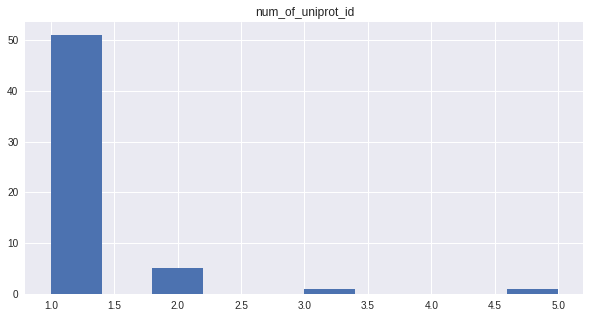

In [5]:
num_uni = []
for cluster_id in set(data_pdb['cluster_id'].tolist()):
    num_uni.append(len(set(data_pdb[data_pdb['cluster_id'] == cluster_id]['uniprot_id'])))
pd.DataFrame({'num_of_uniprot_id': num_uni}).hist(figsize=(10, 5))

<h2>Prepare data</h2>

<h4>For every pdb ID create dataframes contain bioactivities information</h4>

In [6]:
directory = './all/'

In [7]:
uniprot_ids = set(data_pdb['uniprot_id'].tolist())

In [8]:
chembl.create_data_frames(set(data_pdb['uniprot_id'].tolist()), directory=directory) #overwrite=True 

Example file:

In [9]:
pd.read_csv('./all/uniprot/chembl_A9JQL9.csv').head()

,uniprot_id,chembl_id,smiles,bioactivity_type,operator,value,units
0,A9JQL9,CHEMBL525377,Cc1ccc(cc1)c2ccc(CCCN(O)C(=O)CP(=O)(O)O)cc2,Ki,>,7000.0,nM
1,A9JQL9,CHEMBL495807,CC(=O)NP(=O)(O)OCCCc1cccc(Oc2ccccc2)c1,IC50,=,8.0,nM
2,A9JQL9,CHEMBL497815,OP(=O)(O)CC(=O)NCCCc1ccc(cc1)c2ccccc2,Ki,=,810.0,nM
3,A9JQL9,CHEMBL561057,CC(=CCC\C(=C\CNCCNC1C2CC3CC(CC1C3)C2)\C)C,IC50,=,100000.0,nM
4,A9JQL9,CHEMBL561057,CC(=CCC\C(=C\CNCCNC1C2CC3CC(CC1C3)C2)\C)C,Ki,=,360.0,nM


<h2>Analysis:</h2> <h3>Frequency of bioactivity type</h3>

In [10]:
all_bioact = chembl.find_all_type_of_bioact(uniprot_ids, directory)
frequency_bioact = {}
for bioact in all_bioact:
    frequency_bioact[bioact] = 0

for uniprot_id in uniprot_ids:
    
    f = os.path.join(directory, 'uniprot', 'chembl_%s.csv' % uniprot_id)
    data = pd.read_csv(f)
    for bioact in all_bioact:
        
        frequency_bioact[bioact] += (data['bioactivity_type'] == bioact).any()
        
for bioact in all_bioact:
    frequency_bioact[bioact] /= len(uniprot_ids)

frequency_bioact = pd.DataFrame(frequency_bioact, index=['%']).T

In [11]:
frequency_bioact.sort_values(by='%', ascending=False, inplace=True)
frequency_bioact.head(10)

,%
IC50,0.705882
Ki,0.588235
Inhibition,0.588235
Kd,0.529412
Activity,0.514706
EC50,0.294118
Ratio,0.279412
Ratio IC50,0.264706
Km,0.250000
Selectivity,0.191176


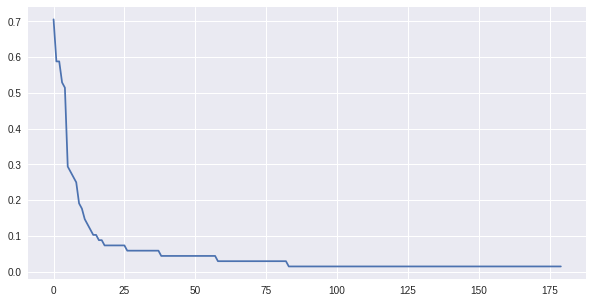

In [12]:
plt.figure(figsize=((10, 5)))
plt.plot(frequency_bioact['%'].values)

<h3>Frequency of units</h3>

In [13]:
all_units = chembl.find_all_units(uniprot_ids, directory)
frequency_units = {}
for unit in all_units:
    frequency_units[unit] = 0

for uniprot_id in uniprot_ids:
    f = os.path.join(directory, 'uniprot', 'chembl_%s.csv' % uniprot_id)
    data = pd.read_csv(f)
    for unit in all_units:
        frequency_units[unit] += (data['units'] == unit).any()
        
for unit in all_units:
    frequency_units[unit] /= len(uniprot_ids)

frequency_units = pd.DataFrame(frequency_units, index=['%']).T

In [14]:
frequency_units.sort_values(by='%', ascending=False, inplace=True)
frequency_units.head(10)

,%
nM,0.750000
%,0.602941
Unspecified,0.455882
uM,0.411765
ug.mL-1,0.161765
degrees C,0.117647
s-1,0.117647
/M/s,0.073529
/s,0.073529
M-1 s-1,0.073529


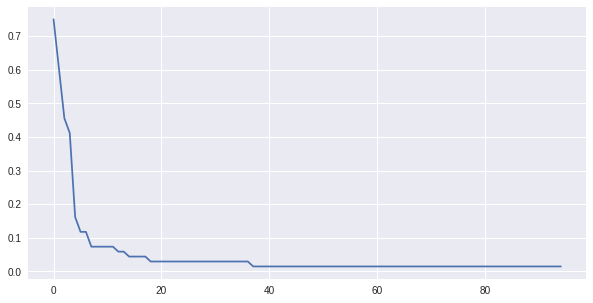

In [15]:
plt.figure(figsize=((10, 5)))
plt.plot(frequency_units['%'].values)

<h2>Data blopking</h2>

In [16]:
frequency_bioact[frequency_bioact['%'] > 0.15]

,%
IC50,0.705882
Ki,0.588235
Inhibition,0.588235
Kd,0.529412
Activity,0.514706
EC50,0.294118
Ratio,0.279412
Ratio IC50,0.264706
Km,0.250000
Selectivity,0.191176


In [17]:
bioactives = ['IC50', 'Ki', 'Inhibition', 'Kd', 'Activity', 'EC50', 'Km', 'Ka']
# No: Ratio, Ratio IC50, Selectivity
# Yes: INH?
units = ['nM', '%']

In [18]:
for uniprot_id in uniprot_ids:
    
    f = os.path.join(directory, 'uniprot', 'chembl_%s.csv' % uniprot_id)
    data = pd.read_csv(f)

    data = data.loc[data['smiles'] != 'Unspecified'] # drop Unspecified smiles
    
    data = data[data['bioactivity_type'].isin(bioactives)] # only chosen bioactivity types
        
    data = chembl.convert_units(data) # convert units

    data = data.loc[data['value'] >= 0 | (data['units'] != '%')]  # drop % < 0

    data = data[data['units'].isin(units)] # only chosen units


    # BLOP
    idx = data.index[((data['units'] == 'nM') & 
            (data['bioactivity_type'] == 'Activity')) | ((data['bioactivity_type'] == 'EC50') & 
                                                            (data['units'] == '%'))]
    data.drop(idx, inplace=True)
        
    data.drop_duplicates(inplace=True)

    data.to_csv(f, index=False)


In [19]:
def table_type_unit(uniprot_id, directory, all_act_type, all_units):

    f = os.path.join(directory, 'uniprot', 'chembl_%s.csv' % uniprot_id)
    if os.path.isfile(f):
        data = pd.read_csv(f)
        count = {}
        for act_type in all_act_type:
            count[act_type] = []
            query = data[data['bioactivity_type'] == act_type]
            for unit in all_units:
                count[act_type].append(sum(query['units'] == unit))

        return pd.DataFrame(count, index=all_units)
    

In [20]:
type_unit = sum([table_type_unit(uniprot_id, directory, bioactives, units) for uniprot_id in uniprot_ids])
type_unit

,Activity,EC50,IC50,Inhibition,Ka,Kd,Ki,Km
nM,0,5567,54320,0,63,2571,29072,134
%,3457,0,0,19758,0,0,0,0


In [21]:
pd.read_csv('./all/uniprot/chembl_A9JQL9.csv').head()

,uniprot_id,chembl_id,smiles,bioactivity_type,operator,value,units
0,A9JQL9,CHEMBL525377,Cc1ccc(cc1)c2ccc(CCCN(O)C(=O)CP(=O)(O)O)cc2,Ki,>,7000.0,nM
1,A9JQL9,CHEMBL495807,CC(=O)NP(=O)(O)OCCCc1cccc(Oc2ccccc2)c1,IC50,=,8.0,nM
2,A9JQL9,CHEMBL497815,OP(=O)(O)CC(=O)NCCCc1ccc(cc1)c2ccccc2,Ki,=,810.0,nM
3,A9JQL9,CHEMBL561057,CC(=CCC\C(=C\CNCCNC1C2CC3CC(CC1C3)C2)\C)C,IC50,=,100000.0,nM
4,A9JQL9,CHEMBL561057,CC(=CCC\C(=C\CNCCNC1C2CC3CC(CC1C3)C2)\C)C,Ki,=,360.0,nM


<h3>Create cluster files</h3>

In [22]:
for cluster in set(data_pdb['cluster_id'].tolist()):
    idx = data_pdb.index[data_pdb['cluster_id'] == cluster]

    cluster_data = []
    for uniprot_id in set(data_pdb['uniprot_id'][idx]):
        f = os.path.join('./all/uniprot/', 'chembl_%s.csv' % uniprot_id)
        if os.path.isfile(f):
            cluster_data.append(pd.read_csv(f))
    if cluster_data:
        cluster_data = pd.concat(cluster_data)
        cluster_data.to_csv('./all/cluster/chembl_%s.csv' % cluster, index=False)
